In [1]:
#####BoW matching with Kernel embedding model#####
import numpy as np
import pandas as pd
import matplotlib.pyplot  as plt
import numpy.matlib
import scipy.linalg
import itertools
from scipy import sparse
from pandas.tools.plotting import scatter_matrix
from numpy.random import *
from scipy import optimize
from scipy.stats import norm
import seaborn as sns

#np.random.seed(98537)

In [2]:
##多項分布の乱数を生成する関数
def rmnom(pr, n, k, no):
    z_id = np.argmax((np.cumsum(pr, axis=1) >= np.random.uniform(0, 1, n)[:, np.newaxis]), axis=1)
    Z = sparse.coo_matrix((np.repeat(1, n), (no, np.array(z_id))), shape=(n, k))   #スパース行列の設定
    return Z

In [3]:
####データの発生####
##データの設定
k = 10
n = 100
d = np.random.poisson(np.random.gamma(5, 1/0.225, n)); d[d <= 1] = 1   #文書あたりの組み合わせ数
D = np.sum(d)   #総文書数
v = 1000   #語彙数
w = np.random.poisson(np.random.gamma(20, 1/0.2, D), D)   #文書あたりの単語数
f = np.sum(w)   #総単語数

In [4]:
##文書IDの組み合わせとインデックスを生成
#文書IDを作成
w_id = np.repeat(np.arange(D), w)
id_list = [i for i in range(D)]
for i in range(D):
    id_list[i] = np.array(np.where(w_id==i)[0], dtype="int")

#文書の組み合わせを生成
id_list1 = [i for i in range(n)]
id_list2 = [i for i in range(n)]
max_id = 0
for i in range(n):
    d_matrix1 = np.triu(np.full((d[i], d[i]), np.arange(d[i]) + max_id).T, k=1)
    d_matrix2 = np.triu(np.full((d[i], d[i]), np.arange(d[i]) + max_id), k=1)
    target = np.triu(np.full((d[i], d[i]), 1), k=1)
    id_list1[i] = d_matrix1[target==1] 
    id_list2[i] = d_matrix2[target==1] 
    max_id = np.max(np.append(id_list1[i], id_list2[i])) + 1
    
#リストをIDに変換
d_id1 = np.array(list(itertools.chain(*[id_list1[i] for i in range(n)])))
d_id2 = np.array(list(itertools.chain(*[id_list2[i] for i in range(n)])))
N = d_id1.shape[0]

#インデックスを作成
target = [i for i in range(D)]
d_list = [i for i in range(D)]
d_list1 = [i for i in range(D)]
d_list2 = [i for i in range(D)]
pt = np.repeat(0, D)
for i in range(D):
    d_list1[i] = np.array(np.where(d_id1==i)[0], dtype="int32")
    d_list2[i] = np.array(np.where(d_id2==i)[0], dtype="int32")
    d_list[i] = np.append(d_list1[i], d_list2[i])
    target[i] = np.append(np.repeat(0, d_list1[i].shape[0]), np.repeat(1, d_list2[i].shape[0]))
    pt[i] = target[i].shape[0]

0.7511456330501071

0.3734730782005388
2.6988103727801542


(array([5662., 2421., 1713., 1343., 1092.,  928.,  808.,  766.,  768.,
         670.,  663.,  550.,  581.,  588.,  563.,  577.,  568.,  569.,
         588.,  614.,  645.,  717.,  898., 1092., 1713.]),
 array([3.24162609e-05, 4.00297164e-02, 8.00270165e-02, 1.20024317e-01,
        1.60021617e-01, 2.00018917e-01, 2.40016217e-01, 2.80013517e-01,
        3.20010817e-01, 3.60008117e-01, 4.00005418e-01, 4.40002718e-01,
        4.80000018e-01, 5.19997318e-01, 5.59994618e-01, 5.99991918e-01,
        6.39989218e-01, 6.79986519e-01, 7.19983819e-01, 7.59981119e-01,
        7.99978419e-01, 8.39975719e-01, 8.79973019e-01, 9.19970319e-01,
        9.59967619e-01, 9.99964920e-01]),
 <a list of 25 Patch objects>)

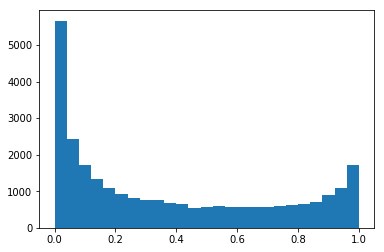

In [35]:
##モデルパラメータを生成
#単語の埋込ベクトルを生成
mu = np.random.normal(-0.25, 1.5, k)
theta = np.random.multivariate_normal(mu, np.diag(np.repeat(9.0, k)), v)
beta = np.array([-1.0])
betat = beta.copy(); thetat = theta.copy()

#文書ごとの単語を生成
m = 50
gamma = np.random.dirichlet(np.repeat(0.1, m), D)
phi = np.random.dirichlet(np.repeat(0.1, v), m)
z = np.dot(np.array(rmnom(gamma[w_id, ], f, m, np.arange(f)).todense()), np.arange(m))
wd_list = [i for i in range(D)]
for i in range(D):
    wd_list[i] = np.array(np.dot(rmnom(phi[z[id_list[i]], ], w[i], v, np.arange(w[i])).todense(), np.arange(v))).reshape(-1)
wd = np.array(list(itertools.chain(*[wd_list[i] for i in range(D)])))

##2文書間のマッチング有無を生成
#2文書間の距離をカーネル関数で表現
w_sq = np.repeat(0, N)
distance = np.repeat(0.0, N)
for i in range(N):    
    id1 = d_id1[i]; id2 = d_id2[i]
    theta_d1 = theta[wd_list[id1], ]
    theta_d2 = theta[wd_list[id2], ]
    w_sq[i] = w[id1]*w[id2]
    distance[i] = np.sum(np.dot(theta_d1, theta_d2.T)) / (w[id1]*w[id2])
    
#ベルヌーイ分布から応答変数を生成
logit = beta + (distance - np.mean(distance))
Prob = np.exp(logit) / (1 + np.exp(logit))
y = np.random.binomial(1, Prob, N)
y_vec = y[:, np.newaxis]

#生成した応答変数を確認
print(np.mean(y))
print(np.std(distance))
plt.hist(Prob, bins=25)

In [38]:
####最尤法でパラメータを推定####
##パラメータを推定するための関数
#対数尤度関数を計算する関数
def loglike(theta, tau, y, d_id1, d_id2, w_sq, N, v, k):
    #パラメータの設定
    beta = theta[0]
    theta_dt = theta[1:].reshape(v, k)
    
    #文書間のカーネル埋め込みを定義
    distance = np.repeat(0.0, N)
    for i in range(N):   
        id1 = d_id1[i]; id2 = d_id2[i]
        theta_d1 = theta[wd_list[id1], ]
        theta_d2 = theta[wd_list[id2], ]
        distance[i] = np.sum(np.dot(theta_d1, theta_d2.T)) / (w_sq[i])

    #ベルヌーイ分布から応答変数を生成
    logit = beta + distance
    Prob = np.exp(logit) / (1 + np.exp(logit))

    #対数尤度の和
    penalty = tau/2 * np.dot(theta_vec, theta_vec) 
    LL = np.sum(y*np.log(Prob) + (1-y)*np.log(1-Prob))
    LLho = LL + penalty
    return LLho 

In [37]:

np.arange(k)[1:]

array([1, 2, 3, 4, 5, 6, 7, 8, 9])

In [22]:
theta_vec.reshape(v, k)

ValueError: cannot reshape array of size 50000 into shape (1000,10)

In [19]:
tau = 0.01

0.01